In [1]:
# Installing required packages
!pip install --upgrade transformers
!pip install --upgrade accelerate
!pip install kaggle
!pip install transformers datasets
!pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Us

In [2]:
# Importing necessary libraries
import os
import torch
import random
import re
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, TensorDataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
sns.set(color_codes=True)

In [3]:
# Downloading the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 96% 78.0M/80.9M [00:04<00:00, 22.7MB/s]
100% 80.9M/80.9M [00:04<00:00, 17.5MB/s]


In [4]:
# Unzipping the data files
!unzip sentiment140.zip -d sentiment140

Archive:  sentiment140.zip
  inflating: sentiment140/training.1600000.processed.noemoticon.csv  


In [5]:
# Loading the dataset
Data = pd.read_csv('sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding='latin-1',  header = None,
                 names=['target', 'ids', 'date', 'flag', 'user', 'text'])

In [6]:
# Printing Data information
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None


In [7]:
# Dropping unrequired data columns
Data = Data.drop(['ids', 'date', 'flag', 'user'], axis=1)

In [8]:
# Displaying the first few rows
print(Data.head())

   target                                               text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....


In [9]:
# checking null values
print(Data.isnull().sum())

target    0
text      0
dtype: int64


In [10]:
# Data summary
print(Data.describe())

             target
count  1.600000e+06
mean   2.000000e+00
std    2.000001e+00
min    0.000000e+00
25%    0.000000e+00
50%    2.000000e+00
75%    4.000000e+00
max    4.000000e+00


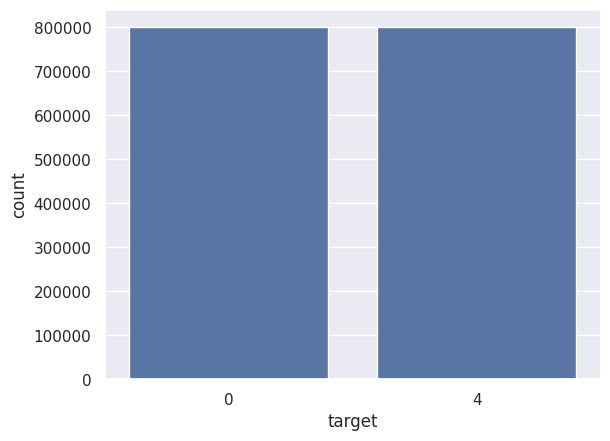

In [11]:
# Visualising the data
sns.countplot(x='target', data=Data)
plt.show()

In [12]:
# Setting the placeholder names
Hashtags = re.compile(r"^#\S+|\s#\S+")
Mentions = re.compile(r"^@\S+|\s@\S+")
URLs = re.compile(r"https?://\S+")

In [13]:
# Defining a function for processing the text
def TextProcessing(text):
    text = re.sub(r'http\S+', '', text)
    text = Hashtags.sub(' hashtag', text)
    text = Mentions.sub(' entity', text)
    return text.strip().lower()

In [14]:
# Processing the text using applied function
Data['ProcessedText'] = Data.text.apply(TextProcessing)

In [15]:
# Checking the data after processing the text
Data.head()

,target,text,ProcessedText
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","entity - awww, that's a bummer. you shoulda ..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,entity i dived many times for the ball. manage...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","entity no, it's not behaving at all. i'm mad. ..."


In [16]:
# Ensuring labels are correct for binary classification (0 and 4 -> 0 and 1)
Data['target'] = Data['target'].apply(lambda x: 0 if x == 0 else 1)

In [17]:
# Setting the labels and text
Labels = Data.target.values
Text = Data.ProcessedText.values

In [18]:
# Setting the tokeniser
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# Tokenizing the text
input_ids = []
attention_mask = []

for i in Text:
    encoded_data = tokenizer.encode_plus(
        i,
        add_special_tokens=True,
        max_length=64,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])

InputID = torch.cat(input_ids, dim=0)
AttentionMask = torch.cat(attention_mask, dim=0)
Labels = torch.tensor(Labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
# Setting the parameters for the model
Dataset = TensorDataset(InputID,AttentionMask,Labels)
TrainingDataSize = int(0.8*len(Dataset))
ValidationDataSize = len(Dataset) - TrainingDataSize

In [21]:
# Setting the training and testing data size
train_dataset,val_dataset = random_split(Dataset,[TrainingDataSize,ValidationDataSize])

In [22]:
# Printing the training and testing data size
print('Training Size - ',TrainingDataSize)
print('Validation Size - ',ValidationDataSize)

Training Size -  1280000
Validation Size -  320000


In [23]:
# DataLoader for training and validation
TrainingData = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
ValidationData = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)

In [24]:
# Setting the Model appication
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_attentions = False, output_hidden_states = False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [25]:
# Setting the seeding parameters for the model
SeedingValidity = 17
random.seed(SeedingValidity)
np.random.seed(SeedingValidity)
torch.manual_seed(SeedingValidity)
torch.cuda.manual_seed_all(SeedingValidity)

In [26]:
# Setting the device for model computation
ModelDevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(ModelDevice)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [27]:
# Setting the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
# Setting up the scheduler
Epoches = 1
TotalTrainingSteps = len(TrainingData) * Epoches
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=TotalTrainingSteps)

In [29]:
# Defining a function for accuracy calculation
def PrintAccuracy(preds, labels):
    PredictionFlats = np.argmax(preds, axis=1).flatten()
    LabellingFlats = labels.flatten()
    return np.sum(PredictionFlats == LabellingFlats) / len(LabellingFlats)

In [30]:
# Defining a function for model evaluation
def ModelEvaluation(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_test:
        batch = tuple(b.to(ModelDevice) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals

In [31]:
# Training the model
torch.cuda.empty_cache()
for epoch in tqdm(range(1, Epoches + 1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(TrainingData, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(ModelDevice) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(TrainingData)
    tqdm.write(f'Training loss: {loss_train_avg}')
    val_loss, predictions, true_vals = ModelEvaluation(ValidationData)
    val_acc = PrintAccuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/40000 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3232560613886453
Validation loss: 0.29541428225524724
Validation accuracy: 0.8743125
